## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = data_path + 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = data_path + 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = data_path + 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = data_path + 'uniprotdomains.gz'
gene_domain_file_path = data_path + 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
bipex_variants_file_path = data_path + 'BipEx_variant_results.tsv.bgz'
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'
ukb_variants_file_path = data_path + 'ukb24310_c19.qced_nonrel.vmiss.gz'

## Define helper methods

In [4]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')
    
    print(cases_df)

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])
    print(unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand'))
    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Load data

In [5]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [6]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [7]:
# Read the data into a DataFrame
bipex_variant_results_df = pd.read_csv(bipex_variants_file_path, sep='\t', compression='gzip')
bipex_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,cadd,mpc,polyphen,group,variant_id,ac_case,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,in_gnomad_non_neuro
0,chr1:13557,"[""G"",""A""]",ENSG00000223972,non_coding,n.805G>A,NaN,4.243,NaN,NaN,Bipolar Disorder,chr1:13557:G:A,0,27098,2,28072,NaN,NaN,NaN,True,True
1,chr1:13557,"[""G"",""A""]",ENSG00000223972,non_coding,n.805G>A,NaN,4.243,NaN,NaN,Bipolar Disorder (including Schizoaffective),chr1:13557:G:A,0,27640,2,28072,NaN,NaN,NaN,True,True
2,chr1:13557,"[""G"",""A""]",ENSG00000223972,non_coding,n.805G>A,NaN,4.243,NaN,NaN,Bipolar Disorder 1,chr1:13557:G:A,0,16012,2,28072,NaN,NaN,NaN,True,True
3,chr1:13557,"[""G"",""A""]",ENSG00000223972,non_coding,n.805G>A,NaN,4.243,NaN,NaN,Bipolar Disorder 2,chr1:13557:G:A,0,6712,2,28072,NaN,NaN,NaN,True,True
4,chr1:13557,"[""G"",""A""]",ENSG00000223972,non_coding,n.805G>A,NaN,4.243,NaN,NaN,Bipolar Disorder with Psychosis,chr1:13557:G:A,0,8566,2,28072,NaN,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23132373,chrX:156025417,"[""G"",""A""]",ENSG00000182484,non_coding,n.3998G>A,NaN,0.635,NaN,NaN,Bipolar Disorder (including Schizoaffective),chrX:156025417:G:A,6,28342,4,28756,0.35482,0.336310,0.56197,False,True
23132374,chrX:156025417,"[""G"",""A""]",ENSG00000182484,non_coding,n.3998G>A,NaN,0.635,NaN,NaN,Bipolar Disorder 1,chrX:156025417:G:A,6,16442,4,28756,0.98354,2.611800,0.10607,False,True
23132375,chrX:156025417,"[""G"",""A""]",ENSG00000182484,non_coding,n.3998G>A,NaN,0.635,NaN,NaN,Bipolar Disorder 2,chrX:156025417:G:A,0,6862,4,28756,-0.92304,0.486430,0.48552,False,True
23132376,chrX:156025417,"[""G"",""A""]",ENSG00000182484,non_coding,n.3998G>A,NaN,0.635,NaN,NaN,Bipolar Disorder with Psychosis,chrX:156025417:G:A,3,8786,4,28756,0.78218,1.092200,0.29599,False,True


In [9]:
# # Read the data into a DataFrame
# bipex_variant_results_df = pd.read_csv(bipex_variants_file_path, sep='\t', compression='gzip')

# Split locus into chr and pos and convert to integers
bipex_variant_results_df[['chr', 'pos']] = bipex_variant_results_df['locus'].str.split(':', expand=True)
bipex_variant_results_df['pos'] = bipex_variant_results_df['pos'].astype(int)

# Filter out rows
bipex_variant_results_df = bipex_variant_results_df[(bipex_variant_results_df['chr'] != "chrX") & (bipex_variant_results_df['chr'] != "chrY") & (bipex_variant_results_df['chr'] != "chrMT")]

filter_consequence_list = [
    "synonymous",
    "non_coding",
    "NA"
]

# Filter rows
bipex_variant_results_df = bipex_variant_results_df[~bipex_variant_results_df['consequence'].isin(filter_consequence_list)]
bipex_variant_results_df = bipex_variant_results_df[~bipex_variant_results_df['consequence'].isna()]

# Add gene names
bipex_variant_results_df = pd.merge(bipex_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

bipex_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,cadd,mpc,polyphen,group,...,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,in_gnomad_non_neuro,chr,pos,gene_name
0,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder,...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
1,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder (including Schizoaffective),...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
2,chr1:925922,"[""G"",""A""]",ENSG00000187634,other_missense,c.-20G>A,NaN,22.30,NaN,NaN,Bipolar Disorder 1,...,0,28844,NaN,NaN,NaN,True,False,chr1,925922,SAMD11
3,chr1:925923,"[""G"",""C""]",ENSG00000187634,other_missense,c.-19G>C,NaN,20.20,NaN,NaN,Bipolar Disorder,...,1,28844,NaN,NaN,NaN,True,False,chr1,925923,SAMD11
4,chr1:925923,"[""G"",""C""]",ENSG00000187634,other_missense,c.-19G>C,NaN,20.20,NaN,NaN,Bipolar Disorder (including Schizoaffective),...,1,28844,NaN,NaN,NaN,True,False,chr1,925923,SAMD11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867259,chr22:50782243,"[""C"",""T""]",ENSG00000079974,other_missense,c.52G>A,p.Ala18Thr,18.69,NaN,benign,Bipolar Disorder with Psychosis,...,15,28844,0.31788,0.43477,0.50966,False,True,chr22,50782243,RABL2B
9867260,chr22:50782243,"[""C"",""T""]",ENSG00000079974,other_missense,c.52G>A,p.Ala18Thr,18.69,NaN,benign,Bipolar Disorder without Psychosis,...,15,28844,0.38228,0.45574,0.49962,False,True,chr22,50782243,RABL2B
9867261,chr22:50782290,"[""G"",""C""]",ENSG00000079974,other_missense,c.5C>G,p.Ala2Gly,24.10,NaN,possibly_damaging,Bipolar Disorder,...,0,28844,NaN,NaN,NaN,True,False,chr22,50782290,RABL2B
9867262,chr22:50782290,"[""G"",""C""]",ENSG00000079974,other_missense,c.5C>G,p.Ala2Gly,24.10,NaN,possibly_damaging,Bipolar Disorder (including Schizoaffective),...,0,28844,NaN,NaN,NaN,True,False,chr22,50782290,RABL2B


In [10]:
# Define path to predictions file
rgc_predictions_file_path = results_path + 'HMM_rgc_0.9_over20_chr2_predictions_rgc_wgs.tsv.gz'

# Load in saved predictions for rgc dataset
predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Compare predictions on RGC to Bipolar dataset

In [13]:
# Parameters for analysis
prob_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = bipex_variant_results_df
# predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_predictions_df = predictions_df[(predictions_df['chr'] == 'chr' + str(chromnum)) & 
                                        (predictions_df['prob_0'] >= prob_thr)]
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]
    
    # Filter variant results for positions over probability threshold
    cases_df = pd.merge(chr_predictions_df['pos'],
                        chr_variant_results_df, on='pos')
    
    # Subset analysis to pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'ptv']
    
    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(results_path + 'bipex_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
             pos           locus                     alleles          gene_id  \
10        962795     chr1:962795                  ["G","GC"]  ENSG00000187961   
11        962795     chr1:962795                  ["G","GC"]  ENSG00000187961   
12        962795     chr1:962795                  ["G","GC"]  ENSG00000187961   
13        962795     chr1:962795                  ["G","GC"]  ENSG00000187961   
14        962795     chr1:962795                  ["G","GC"]  ENSG00000187961   
...          ...             ...                         ...              ...   
29464  248521737  chr1:248521737  ["A","ATTTTGTACTTCTACGTC"]  ENSG00000188558   
29465  248521737  chr1:248521737  ["A","ATTTTGTACTTCTACGTC"]  ENSG00000188558   
29466  248521737  chr1:248521737  ["A","ATTTTGTACTTCTACGTC"]  ENSG00000188558   
29467  248521737  chr1:248521737  ["A","ATTTTGTACTTCTACGTC"]  ENS

              0         1
9      2.070270  0.618639
10     2.029911  0.622237
11     1.750713  1.000000
12     0.000000  1.000000
13     0.000000  1.000000
...         ...       ...
19237       inf  0.496298
19238       inf  0.363548
19262       inf  0.491377
19263       inf  0.496298
19264       inf  0.192859

[1449 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 3
             pos           locus    alleles          gene_id consequence  \
127      4362218    chr3:4362218  ["G","A"]  ENSG00000144455         ptv   
128      4362218    chr3:4362218  ["G","A"]  ENSG00000144455         ptv   
129      4362218    chr3:4362218  ["G","A"]  ENSG00000144455         ptv   
130      4362218    chr3:4362218  ["G","A"]  ENSG00000144455         ptv   
131      43622

        0         1
14    0.0  0.500139
15    0.0  0.500018
16    0.0  0.537217
17    0.0  1.000000
18    0.0  1.000000
...   ...       ...
9657  inf  0.209060
9728  inf  0.491359
9729  inf  0.496280
9730  inf  0.363520
9731  inf  0.233972

[715 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 5
             pos           locus                        alleles  \
19        182299     chr5:182299  ["GCTGAGCCGCACACGCCAGGC","G"]   
20        182299     chr5:182299  ["GCTGAGCCGCACACGCCAGGC","G"]   
21        182299     chr5:182299  ["GCTGAGCCGCACACGCCAGGC","G"]   
22        182299     chr5:182299  ["GCTGAGCCGCACACGCCAGGC","G"]   
23        182299     chr5:182299  ["GCTGAGCCGCACACGCCAGGC","G"]   
...          ...             ...                            ...  

         0         1
58     inf  0.491411
59     inf  0.496332
60     inf  0.363596
130    0.0  1.000000
131    0.0  1.000000
...    ...       ...
13439  0.0  1.000000
13440  0.0  1.000000
13441  0.0  1.000000
13442  0.0  1.000000
13443  0.0  1.000000

[1134 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 7
             pos           locus              alleles          gene_id  \
0         501206     chr7:501206           ["AT","A"]  ENSG00000197461   
1         501206     chr7:501206           ["AT","A"]  ENSG00000197461   
2         501206     chr7:501206           ["AT","A"]  ENSG00000197461   
3         501206     chr7:501206           ["AT","A"]  ENSG00000197461   
20        741436     chr7:741436           ["CT","C"]  ENSG00000164818   
...       

             0         1
188   3.102831  0.172753
189   3.042274  0.176704
190   3.499818  0.199211
191   0.000000  1.000000
192   4.910611  0.087386
...        ...       ...
8336       inf  0.363307
8337       inf  0.208862
8347       inf  0.491377
8348       inf  0.496298
8349       inf  0.209060

[594 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 9
            pos           locus         alleles          gene_id consequence  \
115      712272     chr9:712272      ["C","CT"]  ENSG00000107104         ptv   
116      712272     chr9:712272      ["C","CT"]  ENSG00000107104         ptv   
117      712272     chr9:712272      ["C","CT"]  ENSG00000107104         ptv   
118      712272     chr9:712272      ["C","CT"]  ENSG00000107104         ptv   
254    

         0         1
61     inf  0.491377
62     inf  0.496298
63     inf  0.192859
95     inf  0.491377
96     inf  0.496298
...    ...       ...
10480  0.0  1.000000
10481  0.0  1.000000
10482  0.0  1.000000
10483  0.0  1.000000
10484  0.0  1.000000

[791 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 11
             pos            locus      alleles          gene_id consequence  \
45        244707     chr11:244707   ["TA","T"]  ENSG00000185627         ptv   
46        244707     chr11:244707   ["TA","T"]  ENSG00000185627         ptv   
47        244707     chr11:244707   ["TA","T"]  ENSG00000185627         ptv   
48        244707     chr11:244707   ["TA","T"]  ENSG00000185627         ptv   
77        314286     chr11:314286    ["G","A"]  ENSG0000018

         0         1
41     0.0  1.000000
42     0.0  1.000000
43     0.0  1.000000
44     0.0  1.000000
45     0.0  1.000000
...    ...       ...
14090  0.0  0.500019
14091  0.0  0.537228
14092  0.0  1.000000
14093  0.0  1.000000
14094  0.0  1.000000

[1127 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 13
            pos            locus     alleles          gene_id consequence  \
53     19666441   chr13:19666441  ["AT","A"]  ENSG00000196199         ptv   
54     19666441   chr13:19666441  ["AT","A"]  ENSG00000196199         ptv   
55     19666441   chr13:19666441  ["AT","A"]  ENSG00000196199         ptv   
56     19671844   chr13:19671844  ["T","TA"]  ENSG00000196199         ptv   
57     19671844   chr13:19671844  ["T","TA"]  ENSG00000196199       

        0    1
36    0.0  1.0
37    0.0  1.0
38    0.0  1.0
39    0.0  1.0
40    0.0  1.0
...   ...  ...
8367  0.0  1.0
8368  0.0  1.0
8369  0.0  1.0
8370  0.0  1.0
8371  0.0  1.0

[624 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 15
            pos            locus        alleles          gene_id consequence  \
54     22927927   chr15:22927927      ["C","T"]  ENSG00000273749         ptv   
55     22927927   chr15:22927927      ["C","T"]  ENSG00000273749         ptv   
56     22927927   chr15:22927927      ["C","T"]  ENSG00000273749         ptv   
288    23365106   chr15:23365106      ["G","A"]  ENSG00000261739         ptv   
289    23365106   chr15:23365106      ["G","A"]  ENSG00000261739         ptv   
...         ...              ...            ..

             0         1
0          inf  0.491359
1          inf  0.496280
2          inf  0.233944
3          inf  0.491341
4          inf  0.496263
...        ...       ...
9269  1.014920  1.000000
9270  1.750713  1.000000
9277  0.000000  1.000000
9278  0.000000  1.000000
9279  0.000000  1.000000

[699 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 17
            pos           locus         alleles          gene_id consequence  \
16       413162    chr17:413162       ["C","T"]  ENSG00000187624         ptv   
17       413162    chr17:413162       ["C","T"]  ENSG00000187624         ptv   
18       413162    chr17:413162       ["C","T"]  ENSG00000187624         ptv   
19       413162    chr17:413162       ["C","T"]  ENSG00000187624         ptv   
43    

             0         1
0     0.665311  0.406398
1     0.652338  0.405077
2     0.500069  0.326571
3     0.363741  0.205734
4     0.545513  0.442785
...        ...       ...
4556  1.014920  1.000000
4557  1.750713  1.000000
4558  3.783681  0.374418
4577  0.000000  1.000000
4578  0.000000  1.000000

[371 rows x 2 columns]
Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19
            pos           locus    alleles          gene_id consequence  \
6        110688    chr19:110688  ["G","T"]  ENSG00000176695         ptv   
7        110688    chr19:110688  ["G","T"]  ENSG00000176695         ptv   
8        110688    chr19:110688  ["G","T"]  ENSG00000176695         ptv   
9        110688    chr19:110688  ["G","T"]  ENSG00000176695         ptv   
10       110688    chr19:110688

Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 21
           pos           locus     alleles          gene_id consequence  \
4     10552716  chr21:10552716  ["AG","A"]  ENSG00000273840         ptv   
5     10552716  chr21:10552716  ["AG","A"]  ENSG00000273840         ptv   
6     10552716  chr21:10552716  ["AG","A"]  ENSG00000273840         ptv   
243   15808863  chr21:15808863   ["C","T"]  ENSG00000155313         ptv   
244   15808863  chr21:15808863   ["C","T"]  ENSG00000155313         ptv   
...        ...             ...         ...              ...         ...   
2298  46556052  chr21:46556052  ["CT","C"]  ENSG00000160305         ptv   
2299  46556052  chr21:46556052  ["CT","C"]  ENSG00000160305         ptv   
2300  46556052  chr21:46556052  ["CT","C"]  ENSG0000016

Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []


,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
0,ENSG00000162825,NBPF20,Bipolar Disorder with Psychosis,7,8810,5,28844,4.586459,0.009766
1,ENSG00000184144,CNTN2,Bipolar Disorder with Psychosis,3,8806,0,28828,inf,0.012808
2,ENSG00000163399,ATP1A1,Bipolar Disorder 2,3,6892,1,28844,12.560459,0.024536
3,ENSG00000143847,PPFIA4,Bipolar Disorder 2,2,6892,0,28844,inf,0.037190
4,ENSG00000162594,IL23R,Bipolar Disorder 2,2,6892,0,28844,inf,0.037190
...,...,...,...,...,...,...,...,...,...
19115,ENSG00000184381,PLA2G6,Bipolar Disorder 1,1,16476,1,28844,1.750713,1.000000
19116,ENSG00000184381,PLA2G6,Bipolar Disorder 2,0,6892,1,28844,0.000000,1.000000
19117,ENSG00000184381,PLA2G6,Bipolar Disorder with Psychosis,0,8810,1,28844,0.000000,1.000000
19118,ENSG00000100092,SH3BP1,Bipolar Disorder without Psychosis,0,7490,1,28484,0.000000,1.000000


In [38]:
# # Parameters for analysis
# prob_thr = 0.6
# cnt_thr = 5
# significance_thr = 1
# variant_results_df = epi25_variant_results_df
# # predictions_df = pd.read_csv(rgc_predictions_file_path, sep='\t')

# filtered_predictions_df = predictions_df[(predictions_df['prob_0'] >= prob_thr)]

# variant_results_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
#                                         (variant_results_df['an_case'] > 0) & 
#                                         (variant_results_df['an_ctrl'] > 0)]

# # Filter variant results for positions over probability threshold
# cases_df = pd.merge(filtered_predictions_df, variant_results_df, on=['chr', 'pos'])

# # Subset analysis to pLoFs
# cases_df = cases_df[cases_df['consequence'].isin(pLoF_consequence_list)]

# # Apply fishers exact test to get signicance scores from cases data
# tested_df = apply_fishers_exact_test(cases_df)

# # Filter rows where p_value < significance threshold and append these rows to the DataFrame
# significant_genes_df = tested_df[tested_df['p_value'] <= significance_thr]

# # Display the sorted DataFrame
# # print(tested_df[tested_df['p_value'] < .0001])
    
# # Write significant_genes_df to a csv to avoid recomputing
# # significant_genes_df.to_csv(results_path + 'bipex_rgc_constraint_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

# significant_genes_df #[significant_genes_df['p_value'] < .0001]

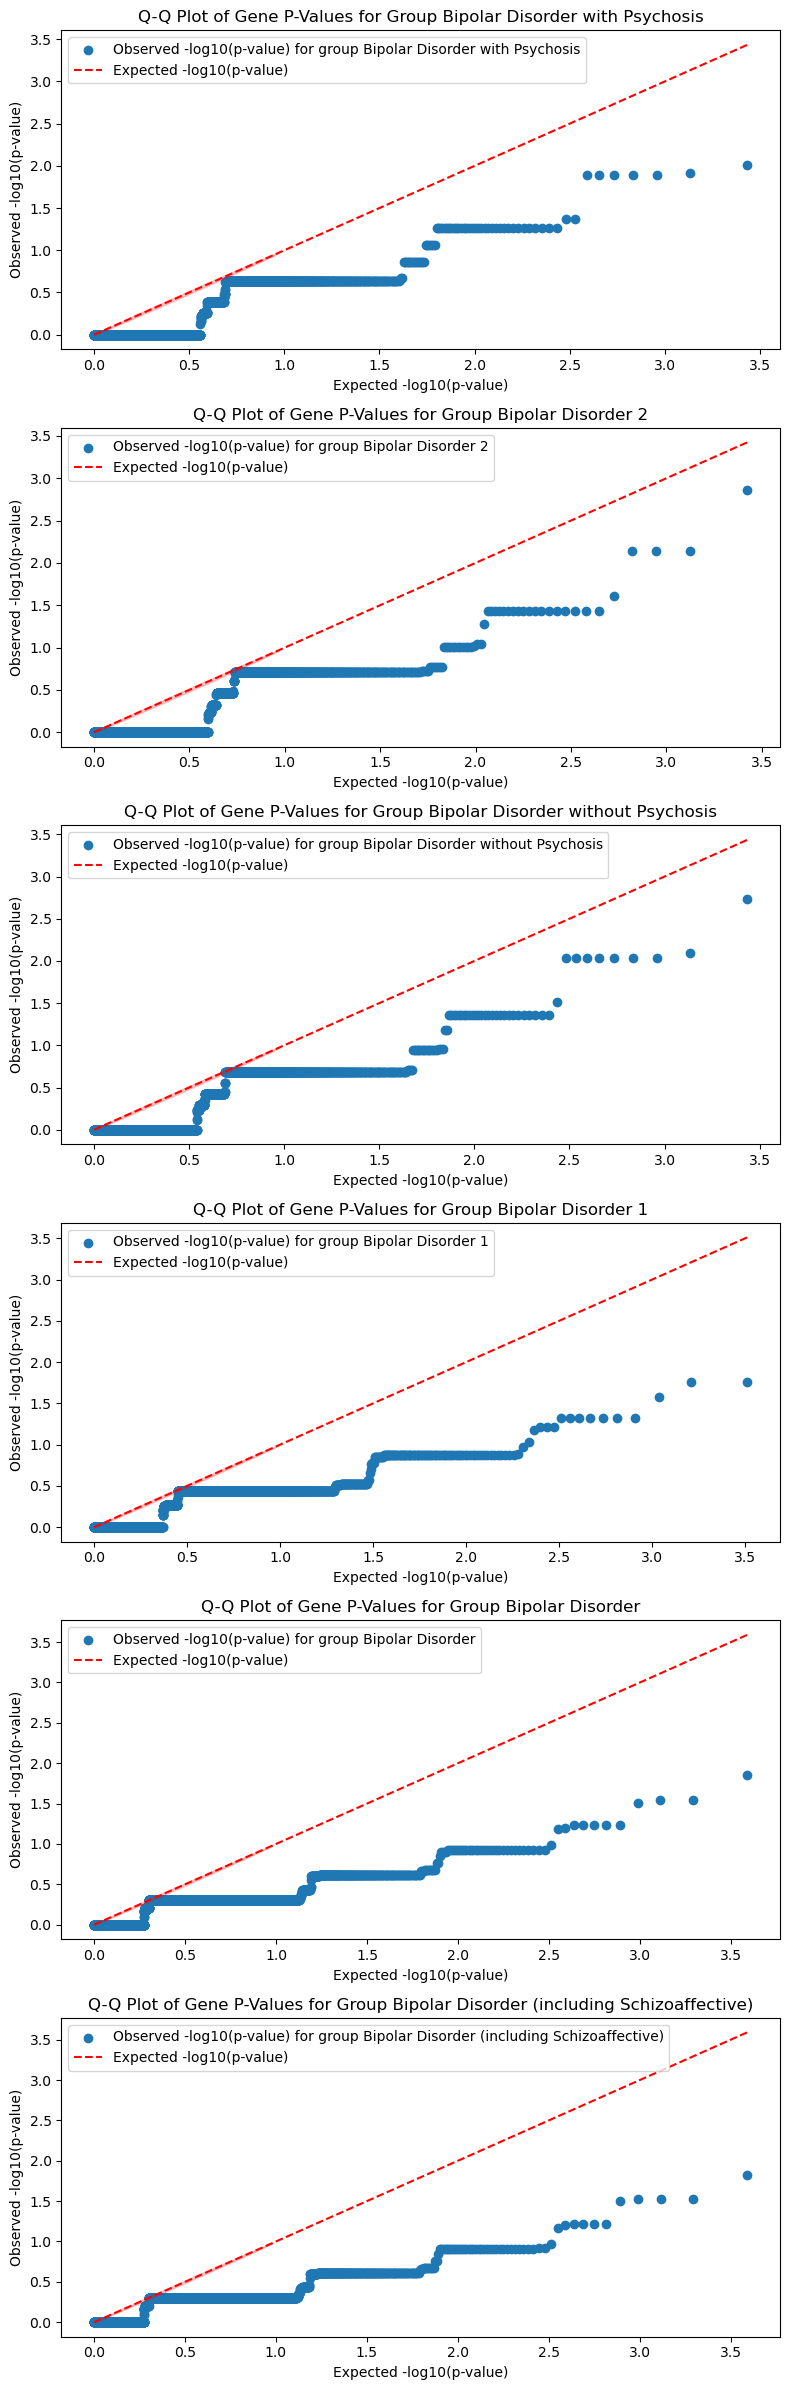

In [14]:
plot_group_QQ(significant_genes_df)

## Combine with Alpha Missense Predictions

In [45]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
variants_filtered_df = variant_results_df[(variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) &
                                          (variant_results_df['an_case'] > 0) &
                                          (variant_results_df['an_ctrl'] > 0)
                                         ].drop(columns=["v", "ref", "alt", "locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "in_analysis"])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(results_path + "constraint_am_aut_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity,gene_id,consequence,group,ac_case,an_case,ac_ctrl,an_ctrl,gene_name,effect_size,var_effect_size
0,chr1,925969,0.019318,0.980682,1.0,0.9695,ENSG00000187634,missense_variant,SWE,0,1490.0,2,7190.0,SAMD11,-0.036067,2.400810
1,chr1,926009,0.000053,0.999947,1.0,0.9415,ENSG00000187634,missense_variant,SWE,0,1490.0,2,7190.0,SAMD11,-0.036067,2.400810
2,chr1,931058,0.002551,0.997449,1.0,0.1961,ENSG00000187634,missense_variant,SWE,0,1490.0,3,7190.0,SAMD11,-0.372678,2.286524
3,chr1,935812,0.000063,0.999937,1.0,0.2191,ENSG00000187634,missense_variant,SWE,0,1490.0,1,7190.0,SAMD11,0.474898,2.667477
4,chr1,939050,0.918669,0.081331,0.0,0.1636,ENSG00000187634,missense_variant,SWE,0,1304.0,1,6180.0,SAMD11,0.456805,2.667595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595738,chr22,50775839,0.000040,0.999960,1.0,0.9849,ENSG00000079974,missense_variant,DBS,0,9622.0,1,10428.0,RABL2B,-1.018270,2.666866
595739,chr22,50776670,0.736335,0.263665,0.0,0.9460,ENSG00000079974,missense_variant,DBS,1,9622.0,0,10428.0,RABL2B,1.179155,2.666866
595740,chr22,50776696,0.000075,0.999925,1.0,0.1056,ENSG00000079974,missense_variant,DBS,1,9622.0,0,10428.0,RABL2B,1.179155,2.666866
595741,chr22,50776706,0.000053,0.999947,1.0,0.9205,ENSG00000079974,missense_variant,DBS,3,9622.0,2,10428.0,RABL2B,0.417031,0.685914


In [46]:
# # Read the data from the file
# merged_df = pd.read_csv(results_path + 'constraint_am_aut_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[~merged_df['consequence'].isin(pLoF_consequence_list)]

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = np.log(gene_data['effect_size'])
    weights = 1 / np.sqrt(gene_data['var_effect_size'])

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
p_values_df.to_csv(results_path + "constraint_am_aut_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
p_values_df

Processing genes:  99%|████████████████████████████████████████████████████████████▎| 36169/36551 [02:35<00:01, 232.90gene/s]


,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall
0,ENSG00000000419,DPM1,DBS,0.751031,0.959147,0.142616,0.943845
1,ENSG00000000419,DPM1,SWE,0.338709,0.158439,0.077556,0.303008
2,ENSG00000000457,SCYL3,DBS,0.990790,0.019185,0.095371,0.053036
3,ENSG00000000457,SCYL3,SWE,0.371301,0.915046,0.498467,0.656506
4,ENSG00000000460,C1orf112,DBS,0.532636,0.338179,0.540336,0.20101
...,...,...,...,...,...,...,...
31684,ENSG00000273171,ENSG00000273171,DBS,NaN,NaN,NaN,nan
31685,ENSG00000273171,ENSG00000273171,SWE,NaN,NaN,NaN,NaN
31686,ENSG00000273173,SNURF,DBS,0.299882,0.070697,0.291504,0.110732
31687,ENSG00000273173,SNURF,SWE,NaN,NaN,NaN,NaN


In [57]:
# significant_genes_df = pd.read_csv(results_path + 'aut_rgc_constraint_pvalues.tsv.gz', sep='\t')
# p_values_df = pd.read_csv(results_path + 'constraint_am_aut_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(p_values_df, significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

joined_p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

joined_p_values_df.rename(columns={'p_value_prob_0': 'p_prob_0', 'p_value_am_pathogenicity': 'p_pathogenicity', 'p_value_const': 'p_const', 'p_value_overall': 'p_overall', 'p_value': 'p_pLoF'}, inplace=True)
# joined_p_values_df[joined_p_values_df['p_overall'] < joined_p_values_df['p_pLoF']]
joined_p_values_df

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
0,ENSG00000000419,DPM1,DBS,0.751031,0.959147,0.142616,0.943845,NaN,0.943845
1,ENSG00000000419,DPM1,SWE,0.338709,0.158439,0.077556,0.303008,NaN,0.303008
2,ENSG00000000457,SCYL3,DBS,0.990790,0.019185,0.095371,0.053036,NaN,0.053036
3,ENSG00000000457,SCYL3,SWE,0.371301,0.915046,0.498467,0.656506,NaN,0.656506
4,ENSG00000000460,C1orf112,DBS,0.532636,0.338179,0.540336,0.20101,NaN,0.201010
...,...,...,...,...,...,...,...,...,...
31874,ENSG00000157601,MX1,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000
31875,ENSG00000157540,DYRK1A,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000
31876,ENSG00000177398,UMODL1,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000
31877,ENSG00000075218,GTSE1,DBS,NaN,NaN,NaN,NaN,0.500706,0.500706


In [58]:
# filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_value_overall'] < 1e-4)
filter_mask = (joined_p_values_df['p_comb'] < 1e-4) | (joined_p_values_df['p_prob_0'] < 1e-4)

gene_name_mask = (joined_p_values_df['gene_name'] == 'SLC2A1')
pd.set_option('display.max_rows', 200)
joined_p_values_df[filter_mask].sort_values('p_comb')

,gene_id,gene_name,group,p_prob_0,p_pathogenicity,p_const,p_overall,p_pLoF,p_comb
1403,ENSG00000057608,GDI2,SWE,2.812587e-16,2.779361e-16,3.517331e-16,0.0,NaN,2.779362e-16
28944,ENSG00000197903,H2BC12,DBS,2.306745e-15,4.556875e-12,1.079298e-14,0.0,NaN,7.830807e-16
31337,ENSG00000253719,ATXN7L3B,DBS,3.447746e-15,3.249354e-15,1.886089e-15,0.0,NaN,1.110662e-15
11475,ENSG00000131910,NR0B2,SWE,1.452972e-15,1.450165e-15,1.518524e-15,0.0,NaN,1.450168e-15
10839,ENSG00000129158,SERGEF,SWE,5.922063e-16,4.637712e-01,3.889315e-16,0.0,NaN,2.268589e-15
31604,ENSG00000262246,CORO7,DBS,3.830729e-15,3.542171e-15,3.207216e-15,0.0,NaN,4.986023e-15
18620,ENSG00000160803,UBQLN4,SWE,7.378266e-16,1.015817e-14,2.395282e-16,0.0,NaN,1.167645e-14
26480,ENSG00000184156,KCNQ3,ASC_DN,1.638280e-14,1.699067e-15,2.571062e-15,0.0,NaN,1.587234e-14
11250,ENSG00000130958,SLC35D2,DBS,4.868847e-14,5.300848e-14,4.434163e-14,0.0,NaN,6.981192e-14
29758,ENSG00000204548,DEFB121,SWE,6.417196e-14,1.069898e-13,2.174760e-16,0.0,NaN,7.759413e-14


In [61]:
print(joined_p_values_df[filter_mask].sort_values('p_comb').to_latex(index=False))

\begin{tabular}{lllrrrlrr}
\toprule
        gene\_id &  gene\_name &  group &     p\_prob\_0 &  p\_pathogenicity &      p\_const & p\_overall &   p\_pLoF &       p\_comb \\
\midrule
ENSG00000057608 &       GDI2 &    SWE & 2.812587e-16 &     2.779361e-16 & 3.517331e-16 &       0.0 &      NaN & 2.779362e-16 \\
ENSG00000197903 &     H2BC12 &    DBS & 2.306745e-15 &     4.556875e-12 & 1.079298e-14 &       0.0 &      NaN & 7.830807e-16 \\
ENSG00000253719 &   ATXN7L3B &    DBS & 3.447746e-15 &     3.249354e-15 & 1.886089e-15 &       0.0 &      NaN & 1.110662e-15 \\
ENSG00000131910 &      NR0B2 &    SWE & 1.452972e-15 &     1.450165e-15 & 1.518524e-15 &       0.0 &      NaN & 1.450168e-15 \\
ENSG00000129158 &     SERGEF &    SWE & 5.922063e-16 &     4.637712e-01 & 3.889315e-16 &       0.0 &      NaN & 2.268589e-15 \\
ENSG00000262246 &      CORO7 &    DBS & 3.830729e-15 &     3.542171e-15 & 3.207216e-15 &       0.0 &      NaN & 4.986023e-15 \\
ENSG00000160803 &     UBQLN4 &    SWE & 7.378266e-

## Compare against published results

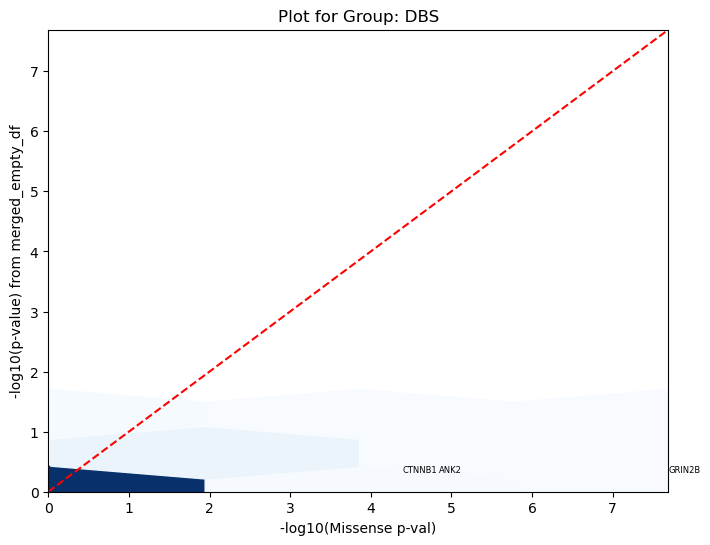

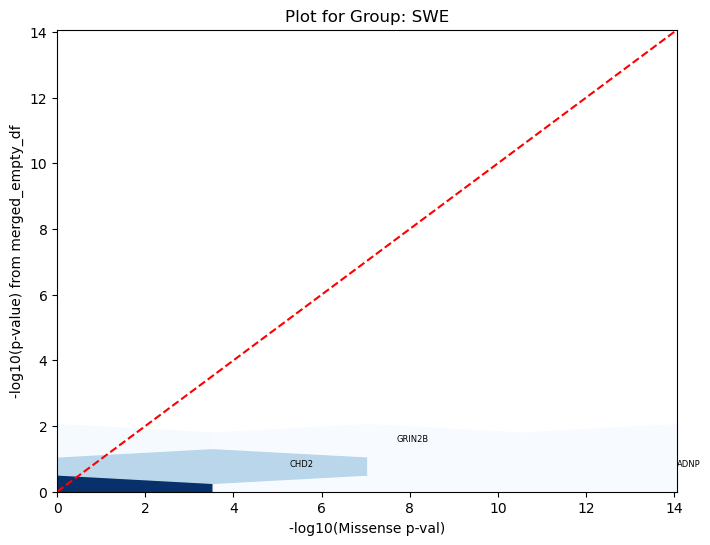

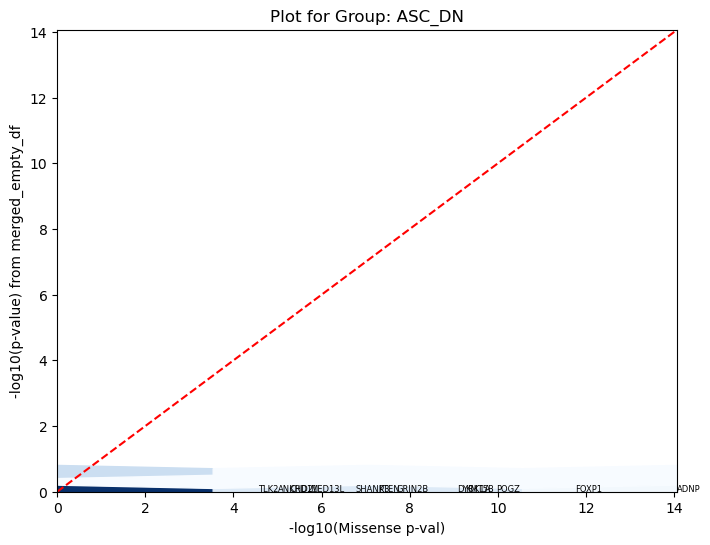

In [60]:
for group in significant_genes_df['group'].unique():
    file_pattern = data_path + "Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")